In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import date2num
import json
from datetime import datetime
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

#### PART 1 - EXPLORATORY DATA ANALYSIS

In [2]:
Logins = pd.read_json('C:/Sumit/scripts/Ultimate Challenge/input/logins.json')
#Logins = pd.read_json('logins.json')

In [3]:
Logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
Logins['Count'] = 1 #Adding a new column 'Count' for each login_time

In [5]:
Logins.head()

,login_time,Count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [6]:
#Grouping login_time in group of 15 min each and the number of counts in total in each interval
Count_15M_Login = Logins.groupby(pd.Grouper(key='login_time', freq='900s')).count().reset_index()

In [7]:
Count_15M_Login.head()

,login_time,Count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [8]:
# Adding two more columns DayOfWeek and Hour using to_datetime
Count_15M_Login['DayOfWeek'] = pd.to_datetime(Count_15M_Login['login_time']).apply(lambda time: time.dayofweek)
Count_15M_Login['Hour'] = pd.to_datetime(Count_15M_Login['login_time']).apply(lambda time: time.hour)

In [9]:
Count_15M_Login.head()

,login_time,Count,DayOfWeek,Hour
0,1970-01-01 20:00:00,2,3,20
1,1970-01-01 20:15:00,6,3,20
2,1970-01-01 20:30:00,9,3,20
3,1970-01-01 20:45:00,7,3,20
4,1970-01-01 21:00:00,1,3,21


In [10]:
# Getting the Counts which are greater than 20 for each day of the week
Count_15M_Login['DayOfWeek'][Count_15M_Login['Count'] > 20].value_counts()

5    310
6    258
4    169
3     92
2     64
1     56
0     30
Name: DayOfWeek, dtype: int64

In [11]:
# Getting the mean of Count for each hour of the day
Count_in_each_hour = Count_15M_Login.groupby(['Hour']).mean()[['Count']]
Count_in_each_hour['Count'] = round(Count_in_each_hour['Count'])

In [12]:
Count_in_each_hour.head()

,Count
Hour,
0,15.0
1,15.0
2,14.0
3,12.0
4,12.0


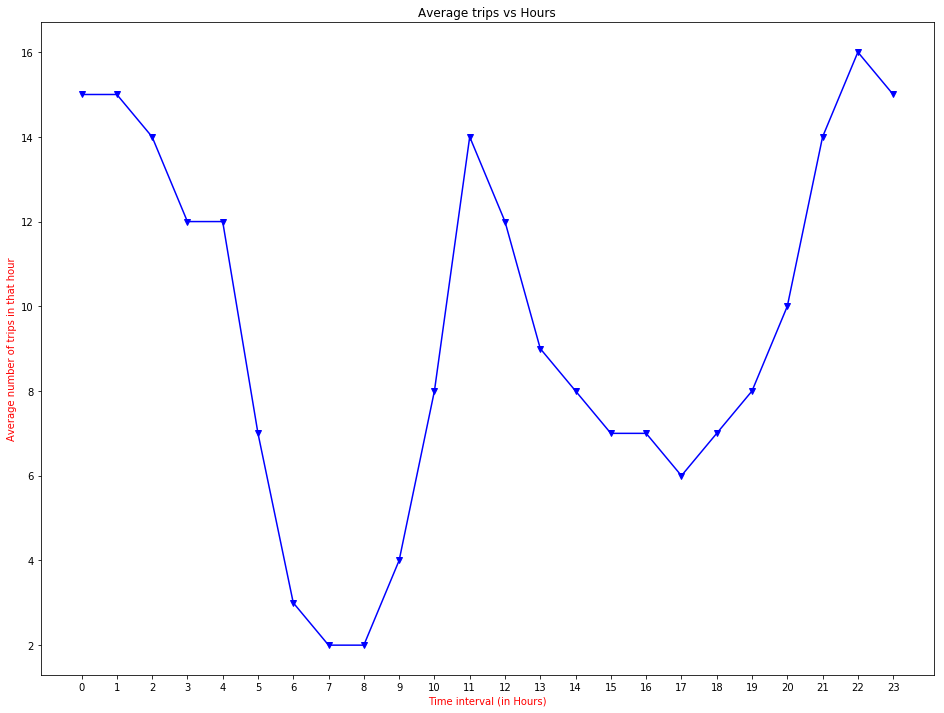

In [13]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(Count_in_each_hour.index, Count_in_each_hour['Count'], marker='v', color='blue')
ax.set_xticks(np.arange(0,24))
ax.set_xlabel('Time interval (in Hours)',color='red')
ax.set_ylabel('Average number of trips in that hour', color='red')
ax.set_title('Average trips vs Hours')
plt.show()

 From above, we see that logins are more in  the late night and early morning between 2100 hours to 0400 hours and between 1100 to 1200 hours in the morning

#### PART II ‑ Experiment and metrics design

##### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Ans : Suggest to check the number of times a driver crosses the bridge. If he crosses more than once, he is entitled for reimbursement

##### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

   ###### a. How you will implement the experiment

Ans : Ultimate can run a promotion of reimbursing all toll cost. Check the number of driver partners who avail the promotion is greater than the group that don't, this is measure the sucess of this experiment

###### b. What statistical test(s) you will conduct to verify the significance of the observation

Ans : the difference in number of crossings for each group can be tested using regression classification taking into account number of hours driven and potentially other factors that might impact crossing unrelated to the promotion

###### c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

Ans : If there is a higher rate of crossing for the group recieving the promotion, Ultimate might consider implementing the promotion for all drivers.

#### Part III ‑ Predictive modeling

In [14]:
with open('C:/Sumit/scripts/Ultimate Challenge/input/ultimate_data_challenge.json') as f:
    ultimate_data = json.load(f)

ultimate_data = pd.DataFrame(ultimate_data)

In [15]:
ultimate_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [16]:
max(ultimate_data['last_trip_date'])

'2014-07-01'

In [17]:
min(ultimate_data['last_trip_date'])

'2014-01-01'

In [18]:
#The users who are travelled within 1 month i.e one month prior to max(last_trip_date) are users are active
#Calculating the active_ind for trips which are occured in the last 30 days
active_ind = (pd.to_datetime(ultimate_data['last_trip_date']) 
                < pd.to_datetime(max(ultimate_data['last_trip_date'])) - pd.Timedelta("30 days")) + 0

In [19]:
active_ind.value_counts()

1    31196
0    18804
Name: last_trip_date, dtype: int64

In [20]:
active_ind.value_counts()[0]/len(active_ind)

0.37608

We see that around 37.6% of the trips are active

In [21]:
#Considering only those features which we will use in the classifer. dropping last_trip_date & signup_date
ultimate_features = ultimate_data.iloc[:,[0,1,2,3,4,6,8,9,10,11]]
ultimate_features.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,Android,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,Android,11.8,14,False,82.4


In [22]:
ultimate_features.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
phone                      396
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

In [23]:
#Filling mean rating for the ratings that are empty by the driver
ultimate_features['avg_rating_by_driver'] = ultimate_features['avg_rating_by_driver'].fillna(ultimate_features.avg_rating_by_driver.mean())

In [24]:
#Filling mean rating for the ratings that are empty of the driver
ultimate_features['avg_rating_of_driver'] = ultimate_features['avg_rating_of_driver'].fillna(ultimate_features.avg_rating_of_driver.mean())

In [25]:
#Filling 0 for phones that are null
ultimate_features['phone'] = ultimate_features['phone'].fillna(0)

In [26]:
ultimate_features.isnull().sum()

avg_dist                  0
avg_rating_by_driver      0
avg_rating_of_driver      0
avg_surge                 0
city                      0
phone                     0
surge_pct                 0
trips_in_first_30_days    0
ultimate_black_user       0
weekday_pct               0
dtype: int64

In [27]:
#Taking the city counts for encoding
ultimate_features.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [28]:
#label encoding city column
ultimate_features['city'] = ultimate_features['city'].map({"Winterfell":0, "Astapor":1, "King's Landing":2})

In [29]:
#Taking  the counts of phone for label encoding
ultimate_features.phone.value_counts()

iPhone     34582
Android    15022
0            396
Name: phone, dtype: int64

In [30]:
# Label encoding phone column
ultimate_features['phone'] = ultimate_features['phone'].map({0:0, 'iPhone':1, 'Android':2})

In [31]:
# Lable encoding ultimate_Black_user
ultimate_features['ultimate_black_user'] = ultimate_features['ultimate_black_user'].map({True:1, False:0})

In [32]:
ultimate_features.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,2,1,15.4,4,1,46.2
1,8.26,5.0,5.0,1.00,1,2,0.0,0,0,50.0
2,0.77,5.0,4.3,1.00,1,1,0.0,3,0,100.0
3,2.36,4.9,4.6,1.14,2,1,20.0,9,1,80.0
4,3.13,4.9,4.4,1.19,0,2,11.8,14,0,82.4


In [33]:
ultimate_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null int64
phone                     50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
dtypes: float64(6), int64(4)
memory usage: 3.8 MB


In [34]:
#Using Decision Tree Classifer for prediction
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

In [35]:
steps = [('scaler', StandardScaler()),
         ('decisiontree', DecisionTreeClassifier())]

In [36]:
pipeline = Pipeline(steps)

In [37]:
parameters = {"decisiontree__max_depth": [3, None],
              "decisiontree__max_features": [1,2,3,4,5,6,7,8,9,10],
              "decisiontree__min_samples_leaf": [1,2,3,4,5,6,7,8,9,10],
              "decisiontree__criterion": ["gini", "entropy"]}

In [38]:
X_train, X_test, y_train, y_test = train_test_split(ultimate_features.values, active_ind.values, test_size=0.3, random_state=1)

In [39]:
gd_cv = GridSearchCV(pipeline, param_grid = parameters)

In [40]:
gd_cv.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'decisiontree__max_depth': [3, None], 'decisiontree__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'decisiontree__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'decisiontree__criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
y_pred = gd_cv.predict(X_test)

In [42]:
print("Best Score:", format(gd_cv.best_score_))
print("Tuned DecisionTree parameters: {}".format(gd_cv.best_params_))

Best Score: 0.7582285714285715
Tuned DecisionTree parameters: {'decisiontree__criterion': 'entropy', 'decisiontree__max_depth': None, 'decisiontree__max_features': 3, 'decisiontree__min_samples_leaf': 10}


The Accuracy score is around 75.6% for DecisionTreeClassifer with hyperparameter tuning

In [43]:
#Trying with RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import permutation_test_score

In [44]:
rf = RandomForestClassifier(max_depth = 5)
score, permutation_scores, pvalue = permutation_test_score(rf, ultimate_features.values, active_ind.values, 
                                                           scoring="accuracy", cv = 5, n_permutations = 100, 
                                                           n_jobs=1)

In [45]:
permutation_scores

array([0.62394   , 0.62378001, 0.62382001, 0.62376001, 0.62378   ,
       0.62379998, 0.62402   , 0.62392001, 0.62386   , 0.62384001,
       0.62395999, 0.62380001, 0.62368   , 0.62398   , 0.62367999,
       0.62373999, 0.62392   , 0.6238    , 0.62374001, 0.62368   ,
       0.62374   , 0.6239    , 0.62394   , 0.6238    , 0.62384   ,
       0.62385999, 0.6238    , 0.62388002, 0.62378   , 0.62386   ,
       0.62386001, 0.62391998, 0.62386   , 0.62372   , 0.62384   ,
       0.62376   , 0.62357999, 0.6238    , 0.62383999, 0.6237    ,
       0.62358   , 0.62376001, 0.62357999, 0.62374   , 0.62386   ,
       0.6238    , 0.62386001, 0.62392   , 0.62382   , 0.62341998,
       0.62384   , 0.62382   , 0.62357999, 0.62374   , 0.62386   ,
       0.62376   , 0.62394   , 0.62387999, 0.62382   , 0.6239    ,
       0.62376   , 0.62377999, 0.62388   , 0.62404001, 0.62364   ,
       0.62373999, 0.62386   , 0.62373998, 0.62386001, 0.62391999,
       0.6237    , 0.62368   , 0.62370001, 0.62378   , 0.62384

In [46]:
score

0.7652602050678021

In [47]:
pvalue

0.009900990099009901

In [48]:
cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

confusion matrix:
[[3669 2040]
 [1613 7678]]


The accuracy score is around 76.7 % for RandomForest classifier. So there is a 76.7% probability that the retention of the active drivers will succeed